In [113]:
from dotenv import load_dotenv
load_dotenv()
import os

OPENAI_API_KEY=os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY=os.getenv('TAVILY_API_KEY')

In [114]:
%pip install -U seaborn

Note: you may need to restart the kernel to use updated packages.


In [115]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5, include_images=True,)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [116]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [117]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")
from langchain_community.chat_models import ChatPerplexity
llm_perplexity = ChatPerplexity(model="llama-3.1-sonar-small-128k-online")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [118]:
@tool
def scrape_branding(url: str) -> dict:
    """Extract branding information from a specific web page."""
    from bs4 import BeautifulSoup
    import requests
    import re
    import colorsys
    import cssutils
    import logging
    
    # Suppress cssutils warning logs
    cssutils.log.setLevel(logging.CRITICAL)
    
    branding_info = {
        'color_palette': [],
        'font_styles': [],
        'logo_url': None,
        'design_elements': [],
        'background_colors': [],
        'text_colors': [],
        'button_styles': [],
        'header_styles': []
    }
    
    try:
        # Add headers to mimic a browser request
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract color palette
        def extract_colors(text):
            # Expanded color pattern to catch more formats
            color_patterns = [
                r'#(?:[0-9a-fA-F]{3}){1,2}\b',  # Hex colors
                r'rgb\(\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\)',  # RGB
                r'rgba\(\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*[\d.]+\s*\)',  # RGBA
                r'hsl\(\s*\d+\s*,\s*[\d.]+%\s*,\s*[\d.]+%\s*\)',  # HSL
                r'hsla\(\s*\d+\s*,\s*[\d.]+%\s*,\s*[\d.]+%\s*,\s*[\d.]+\s*\)'  # HSLA
            ]
            colors = []
            for pattern in color_patterns:
                colors.extend(re.findall(pattern, text))
            return colors
        
        # Check multiple sources for colors
        colors = []
        
        # 1. Check inline styles
        for element in soup.find_all(style=True):
            colors.extend(extract_colors(element['style']))
        
        # 2. Check style tags
        for style in soup.find_all('style'):
            if style.string:
                colors.extend(extract_colors(style.string))
        
        # 3. Check external stylesheets
        for link in soup.find_all('link', rel='stylesheet'):
            href = link.get('href')
            if href:
                if not href.startswith(('http://', 'https://')):
                    href = url + href if not url.endswith('/') else url + '/' + href
                try:
                    css_response = requests.get(href, headers=headers)
                    colors.extend(extract_colors(css_response.text))
                except:
                    continue
        
        # 4. Check background-color and color properties
        for element in soup.find_all():
            style = element.get('style', '')
            if 'background' in style or 'color:' in style:
                colors.extend(extract_colors(style))
        
        # Remove duplicates and sort by brightness
        unique_colors = list(set(colors))
        
        def color_brightness(color):
            # Convert all color formats to RGB
            if color.startswith('#'):
                if len(color) == 4:  # Convert #RGB to #RRGGBB
                    color = '#' + ''.join(c + c for c in color[1:])
                r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)
            elif color.startswith('rgb'):
                r, g, b = map(int, re.findall(r'\d+', color)[:3])
            else:
                return 0  # Default for unsupported formats
            
            return colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)[2]
        
        branding_info['color_palette'] = sorted(unique_colors, key=color_brightness, reverse=True)[:10]
        
        # Extract font styles
        font_styles = []
        # 1. Check style tags
        for style in soup.find_all('style'):
            if style.string:
                font_matches = re.findall(r'font-family:\s*([^;}]+)[;}]', style.string)
                font_styles.extend(font_matches)
        
        # 2. Check inline styles
        for element in soup.find_all(style=True):
            if 'font-family' in element['style']:
                font_matches = re.findall(r'font-family:\s*([^;}]+)[;}]', element['style'])
                font_styles.extend(font_matches)
        
        # 3. Check Google Fonts links
        for link in soup.find_all('link'):
            href = link.get('href', '')
            if 'fonts.googleapis.com' in href:
                font_family = re.search(r'family=([^&]+)', href)
                if font_family:
                    font_styles.append(font_family.group(1).replace('+', ' '))
        
        branding_info['font_styles'] = list(set(font_styles))
        
        # Find logo
        possible_logo_elements = [
            soup.find(['img', 'svg'], class_=re.compile(r'logo|brand|header-logo', re.I)),
            soup.find(['img', 'svg'], id=re.compile(r'logo|brand|header-logo', re.I)),
            soup.find(['img', 'svg'], alt=re.compile(r'logo|brand', re.I)),
            soup.find(['img', 'svg'], src=re.compile(r'logo|brand', re.I))
        ]
        
        for logo in possible_logo_elements:
            if logo and (logo.get('src') or logo.get('data-src')):
                logo_url = logo.get('src') or logo.get('data-src')
                if not logo_url.startswith(('http://', 'https://')):
                    logo_url = url + logo_url if not url.endswith('/') else url + '/' + logo_url
                branding_info['logo_url'] = logo_url
                break
        
        # Extract design elements
        design_elements = soup.find_all(class_=re.compile(r'(design|element|style|brand|component|section|container)', re.I))
        branding_info['design_elements'] = [
            {
                'tag': el.name,
                'classes': el.get('class', []),
                'text': el.get_text(strip=True)[:50],
                'styles': el.get('style', '')
            }
            for el in design_elements[:10]
        ]
        
        # Extract button styles
        buttons = soup.find_all(['button', 'a'], class_=re.compile(r'btn|button', re.I))
        branding_info['button_styles'] = [
            {
                'classes': btn.get('class', []),
                'styles': btn.get('style', ''),
                'text': btn.get_text(strip=True)[:30]
            }
            for btn in buttons[:5]
        ]
        
        # Extract header styles
        headers = soup.find_all(['header', 'nav', 'div'], class_=re.compile(r'header|nav|navbar', re.I))
        branding_info['header_styles'] = [
            {
                'tag': header.name,
                'classes': header.get('class', []),
                'styles': header.get('style', '')
            }
            for header in headers[:3]
        ]
        
        return branding_info
        
    except Exception as e:
        print(f"Error scraping branding: {e}")
        return branding_info

In [138]:
branding_results = scrape_branding("https://aialpha.ai/")
print("Color Palette:", branding_results['color_palette'])
print("\nFont Styles:", branding_results['font_styles'])
print("\nLogo URL:", branding_results['logo_url'])
print("\nButton Styles:", branding_results['button_styles'])
print("\nHeader Styles:", branding_results['header_styles'])
print("\nDesign Elements:", branding_results['design_elements'])

Color Palette: ['#ffdf7e', 'rgba(0,123,255,.5)', '#fff', 'rgba(255, 255, 255, 0.75)', '#9fcdff', '#ffc720', 'rgba(255,255,255,.075)', '#ffcd39', 'rgba(255, 255, 255, 0.25)', 'rgba(255,255,255,.85)']

Font Styles: ['Comfortaa:wght@300', 'Unbounded:wght@200..900', 'Montserrat:wght@200', 'Prompt:ital,wght@0,100;0,200;0,300;0,400;0,500;0,600;0,700;0,800;0,900;1,100;1,200;1,300;1,400;1,500;1,600;1,700;1,800;1,900']

Logo URL: https://aialpha.ai//static/images/navbarLogo.svg

Button Styles: []

Header Styles: []

Design Elements: []


In [120]:
pip install cssutils

Note: you may need to restart the kernel to use updated packages.


In [121]:
@tool
def python_repl_with_branding(
    code: Annotated[str, "The python code to execute to generate your chart."],
) -> str:
    """Use this to execute python code with consistent branding. The chart will be styled according to the website's branding."""
    
    # Get branding information
    branding = scrape_branding("https://aialpha.ai/")
    
    # Prepare branding-specific styling code
    style_code = """
import matplotlib.pyplot as plt
import seaborn as sns

# Set style to a clean, modern look
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with branded dimensions
plt.figure(figsize=(10, 6))

# Apply branded colors
colors = {color_palette}
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors[:5])  # Use first 5 colors

# Set fonts
plt.rcParams['font.family'] = 'sans-serif'
if {font_styles}:
    plt.rcParams['font.sans-serif'] = [{font_styles}[0]]

# Custom style settings
plt.rcParams['axes.labelcolor'] = colors[0]
plt.rcParams['xtick.color'] = colors[0]
plt.rcParams['ytick.color'] = colors[0]
plt.rcParams['axes.titlecolor'] = colors[0]
    """.format(
        color_palette=branding['color_palette'][:5] if branding['color_palette'] else ['#000000'],
        font_styles=branding['font_styles'] if branding['font_styles'] else ['Arial']
    )
    
    # Combine styling code with user's code
    full_code = style_code + "\n" + code
    
    try:
        result = repl.run(full_code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [1]:
# Import required libraries and set up temporary directory for file operations
import yahoofinance as yf
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


# Tool to create and save document outlines
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# Tool to read document contents with optional line range
@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# Tool to write content to a document
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# Tool to edit documents by inserting text at specific line numbers
@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Python REPL tool for executing code
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

# Import required tools and date handling
from langchain_core.tools import tool
from datetime import date

# Tool to get company information
@tool
def company_information(ticker: str) -> dict:
    """Use this tool to retrieve company information like address, industry, sector, company officers, business summary, website,
       marketCap, current price, ebitda, total debt, total revenue, debt-to-equity, etc."""

    ticker_obj = yf.Ticker(ticker)
    ticker_info = ticker_obj.get_info()

    return ticker_info

# Tool to get dividend and earnings dates
@tool
def last_dividend_and_earnings_date(ticker: str) -> dict:
    """
    Use this tool to retrieve company's last dividend date and earnings release dates.
    It does not provide information about historical dividend yields.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_calendar()

# Tool to get mutual fund holders information
@tool
def summary_of_mutual_fund_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top mutual fund holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    mf_holders = ticker_obj.get_mutualfund_holders()

    return mf_holders.to_dict(orient="records")

# Tool to get institutional holders information
@tool
def summary_of_institutional_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top institutional holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    inst_holders = ticker_obj.get_institutional_holders()

    return inst_holders.to_dict(orient="records")

# Tool to get stock grade changes
@tool
def stock_grade_upgrades_downgrades(ticker: str) -> dict:
    """
    Use this to retrieve grade ratings upgrades and downgrades details of particular stock.
    It'll provide name of firms along with 'To Grade' and 'From Grade' details. Grade date is also provided.
    """
    ticker_obj = yf.Ticker(ticker)

    curr_year = date.today().year

    upgrades_downgrades = ticker_obj.get_upgrades_downgrades()
    upgrades_downgrades = upgrades_downgrades.loc[upgrades_downgrades.index > f"{curr_year}-01-01"]
    upgrades_downgrades = upgrades_downgrades[upgrades_downgrades["Action"].isin(["up", "down"])]

    return upgrades_downgrades.to_dict(orient="records")

# Tool to get stock split history
@tool
def stock_splits_history(ticker: str) -> dict:
    """
    Use this tool to retrieve company's historical stock splits data.
    """
    ticker_obj = yf.Ticker(ticker)
    hist_splits = ticker_obj.get_splits()

    return hist_splits.to_dict()

# Tool to get stock news
@tool
def stock_news(ticker: str) -> dict:
    """
    Use this to retrieve latest news articles discussing particular stock ticker.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_news()

NameError: name 'tool' is not defined

In [123]:
tools = [
         company_information,
         last_dividend_and_earnings_date,
         stock_splits_history,
         summary_of_mutual_fund_holders,
         summary_of_institutional_holders,
         stock_grade_upgrades_downgrades,
         stock_news,
         tavily_tool
]

In [133]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4-0125-preview")

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

search_agent = create_react_agent(llm, tools=tools, state_modifier="You are a data gatherer. Your role is to collect comprehensive financial and market data using available tools. Always ensure you gather complete datasets including historical prices, trading volumes, and relevant financial metrics that will be essential for creating detailed visualizations.")
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier="You are a web research specialist. Focus on gathering contextual information, news, and analysis that can complement the financial data. Look for market trends, company announcements, and analyst reports that could provide valuable context for the visualization.")
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

chart_agent = create_react_agent(llm, tools=[python_repl_with_branding], state_modifier="You are a visualization expert. Create compelling charts using both the financial data and branding guidelines. Always include proper titles, labels, and legends. Make sure to handle missing data appropriately and apply the brand's color scheme and styling consistently.")
chart_node = functools.partial(agent_node, agent=chart_agent, name="ChartGenerator")

branding_agent = create_react_agent(llm, tools=[scrape_branding], 
                                    state_modifier="You are a branding specialist. Extract and document all relevant branding elements including colors, fonts, logos, and style guidelines. Provide specific hex codes for colors and detailed styling instructions that can be applied to charts and visualizations.")
branding_node = functools.partial(agent_node, agent=branding_agent, name="BrandingExtractor")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a project supervisor coordinating a visualization workflow. Your team includes: "
    "1. Search: Gathers comprehensive financial and market data "
    "2. WebScraper: Collects supplementary research and context "
    "3. ChartGenerator: Creates professional visualizations "
    "ALWAYS follow this sequence: "
    "1. Coordinate Search and WebScraper to gather ALL necessary data and context "
    "2. Ensure ChartGenerator receives complete datasets and branding information "
    "3. Verify that the final visualization meets all requirements and includes proper context",
    ["Search", "WebScraper", "ChartGenerator"]
)

In [134]:
research_graph = StateGraph(ResearchTeamState)
#research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("Search", search_node)
research_graph.add_node("ChartGenerator", chart_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
#research_graph.add_edge("supervisor", "Search")
research_graph.add_edge("supervisor", "Search")
research_graph.add_edge("Search", "WebScraper")
research_graph.add_edge("WebScraper", "ChartGenerator")


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    # Add a fixed branding extraction prompt
    results = {
        "messages": [
            HumanMessage(content=message)
        ],
    }
    return results


research_chain = enter_chain | chain

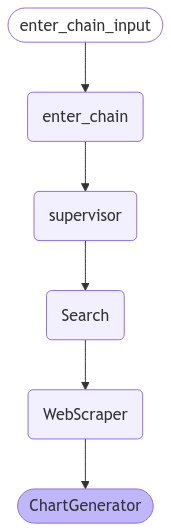

In [126]:
from IPython.display import Image, display

display(Image(research_chain.get_graph().draw_mermaid_png()))


In [137]:
for s in research_chain.stream(
"""
"Visualize the daily closing prices of bitcoin over the year 2020 using a scatter plot."
""",
    {"recursion_limit": 100}

):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='I\'m unable to directly provide visualizations or access real-time or historical cryptocurrency prices. However, to achieve your goal, you would typically follow these steps using a financial data provider or API that offers historical cryptocurrency price data:\n\n1. **Data Acquisition**:\n   - Find a reliable data source that provides daily closing prices of Bitcoin for the year 2020.\n   - Ensure the data includes at least the date and the closing price for each trading day in 2020.\n\n2. **Data Preparation**:\n   - Once you have the data, ensure it\'s in a clean and usable format. You might need to convert the dates into a format that your visualization tool recognizes (e.g., YYYY-MM-DD).\n   - Make sure the closing prices are in a numeric format.\n\n3. **Visualization**:\n   - Choose a visualization tool or programming language with visualization libraries. Tools like Excel, Google Sheets, or pro

In [128]:
for s in research_chain.stream(
    "Create a bar graph to compare the monthly average prices of Amazon stock in 2019.",
    {"recursion_limit": 100}):
    
    if "__end__" not in s:
        output_messages = []
        output_messages.append(s)
# Si hay resultados, procesarlos
    if output_messages:
        for output_message in output_messages:
            classifiers = output_message.get('ChartGenerator', {})
            for valor in classifiers.values():
                for idx, elemento in enumerate(valor, start=1):
                   print(elemento.content)


I encountered an unexpected issue with generating the visualization, which seems to be related to the internal handling of color arguments within the plotting environment. Despite the adjustment, the graph could not be displayed due to this error.

While I'm unable to provide the visual representation directly here, the code snippet I've shared is a valid approach for creating a bar graph with matplotlib in Python. If you have access to a Python environment, you can run the provided code to visualize the hypothetical monthly average prices of Amazon stock for 2019.

If there's anything else I can assist you with or another way you'd like to explore this data, please let me know!


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [129]:
for s in research_chain.stream(
"""

Create a pie chart showing the market share distribution of major cryptocurrency exchanges in 2023

""",
    {"recursion_limit": 100}

):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content="The search results provide a variety of insights into the cryptocurrency exchange market in 2023 but do not directly offer a clear, comprehensive market share distribution of major cryptocurrency exchanges. To construct a precise pie chart, we would ideally need specific percentages or volume metrics for each major exchange's hold on the market. However, based on the information available, we can infer some key details:\n\n1. **Bitvavo** leads in the Netherlands with a 45% traffic share.\n2. **Coinbase** dominates in North America with a 51.1% market share in the United States and Canada, which is 24%.\n3. In Southeast Asia, there's a rising popularity of local exchanges, indicating a fragmented market share with no single dominant exchange mentioned.\n4. The reports and analyses mainly focus on the growth of cryptocurrencies and trading volumes rather than explicitly detailing exchange market shares.

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>